In [1]:
import numpy as np
import pickle
import json
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.onnx
from torch.utils.data.sampler import SubsetRandomSampler
import sys
import os
import threading
import time
import matplotlib.pyplot as plt

In [2]:
# my modules
sys.path.append(os.getcwd() + '/../..')

from models import ShallowCNN
from models import DPCNN
from dataset import dataset
from preprocess import preprocess
from util import readConfig
from train import *
from plot import plots
from scipy import stats

In [3]:
from captum.attr._core import (
    input_x_gradient,
    guided_grad_cam,
    gradient_shap,
    kernel_shap
)

from captum.attr._core.layer import grad_cam

from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    Saliency
)

In [15]:
z0 = torch.zeros((1, 1, model_args['max_len'], model_args['dim']))
z1 = new_embed_layer(test_set[2][0]).view(1, 1, model_args['max_len'], model_args['dim'])

In [16]:
delta = (z1 - z0)/100
delta

tensor([[[[-9.6488e-06,  2.4220e-04,  3.8702e-05,  ..., -2.1418e-04,
           -1.1769e-04,  5.8930e-05],
          [-1.8986e-04,  2.4499e-04,  1.1685e-04,  ..., -3.1111e-04,
           -5.2008e-05, -3.7869e-04],
          [ 7.5046e-05,  1.9131e-04, -1.6848e-04,  ..., -1.8551e-04,
           -2.0559e-04, -5.4522e-05],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]])

In [20]:
dict2save = {}
masst = new_embed_layer(test_set[2][0]).view(1, 1, model_args['max_len'], model_args['dim'])
dict2save[0.0] = model(masst)
for i in range(100):
    masst = masst + delta
    attributions_out = Saliency(model).attribute(masst, target=1, abs=True)
    dict2save[i/100.0] = attributions_out.detach().numpy()[0][0]

In [70]:
dict2save

{0.0: array([[2.71264445e-02, 1.00979926e-02, 8.37698672e-03, ...,
         2.51642847e-03, 3.36377136e-02, 1.15220752e-02],
        [2.27425992e-02, 2.06170622e-02, 2.20961170e-03, ...,
         1.48156416e-02, 1.17248185e-02, 5.23201339e-02],
        [1.24097308e-02, 1.14888288e-02, 3.87824439e-02, ...,
         2.42106966e-03, 8.76001827e-03, 2.85826065e-02],
        ...,
        [8.75161379e-04, 5.27458964e-04, 9.28077789e-04, ...,
         1.63203524e-03, 2.26955116e-03, 5.73670550e-04],
        [6.13994431e-04, 3.90538538e-04, 5.73599653e-04, ...,
         8.52800382e-04, 1.07207824e-03, 8.17310065e-05],
        [1.35631853e-04, 1.49701271e-04, 5.81939006e-04, ...,
         2.18147779e-05, 7.70475424e-04, 4.72720654e-04]], dtype=float32),
 0.01: array([[2.57810242e-02, 9.60438140e-03, 7.97681976e-03, ...,
         2.39623152e-03, 3.20079029e-02, 1.09559186e-02],
        [2.16310266e-02, 1.96100771e-02, 2.11891439e-03, ...,
         1.41128153e-02, 1.11452024e-02, 4.97734398e-02],

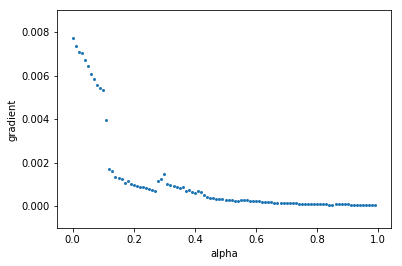

In [34]:
x = list(dict2save.keys())
y = list(dict2save.values())
y = [t[12][210] for t in y]
plt.xlabel("alpha")
plt.ylabel("gradient")
plt.ylim([-0.001, 0.009])
plt.scatter(x,y, s=4)
plt.savefig("./gradients_plots/02_12_210.png", dpi=80)

In [49]:

input = test_set[2][0]
input = new_embed_layer(input)
input = input.view(1, 1, model_args['max_len'], model_args['dim'])
out = model(input)
out

tensor([[-2.9464, -0.0540]], grad_fn=<LogSoftmaxBackward>)

In [4]:
# glove_embed = pickle.load(open("../../../data/embeddings/glove/yelp_polarity/embed.pkl", 'rb'))
# glove_w2i = pickle.load(open("../../../data/embeddings/glove/yelp_polarity/w2i.pkl", 'rb'))
# glove_i2w = pickle.load(open("../../../data/embeddings/glove/yelp_polarity/i2w.pkl", 'rb'))

In [18]:
all_antonyms = {}
with open("../../../data/embeddings/polar/selected1275_yelp/antonyms.txt", "r") as f:
    for line in f:
        lsplit = line.strip().split(",")
        if len(lsplit) == 2 and lsplit[1] != "UNK":
            all_antonyms[lsplit[0]] = lsplit[1]

In [6]:
# b1275 = pickle.load(open("../../../data/embeddings/polar/selected1275_yelp/b1275.pkl", "rb"))
# dim_index = dict([(b,a) for a,b in b1275])
# antonym_vec_dict = {}
# for _, tup in b1275:
#     w1 = tup[0]
#     w2 = tup[1]
#     diff= glove_embed[glove_w2i[w1]] - glove_embed[glove_w2i[w2]]
#     diff = diff / np.linalg.norm(diff)
#     antonym_vec_dict[(w1,w2)] = diff

In [14]:
new_embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(model_args['embedding_matrix'].copy()), freeze = True)
original_embed = np.asarray(model_args['embedding_matrix'].copy())
new_embed = np.asarray(model_args['embedding_matrix']).copy()
zero_embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(np.zeros(new_embed.shape)), freeze = True)
dim_name_dict = dict([(b,a) for a,b in pickle.load(open(args['load_dim_names'], 'rb'))])

# Save original sentences
text_sentences = []
with open(args['input_path'] + '/texts_sentences.data', 'r') as sent_f:
    for line in sent_f:
        text_sentences.append(line.split('<_SEP_>'))

In [19]:
js_data = compute_grads(args, w2i, i2w, cls, texts, test_set, model_args, model,input_index=2, label=1, embeddings=new_embed_layer, method="Saliency")

Saliency


/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


In [ ]:
[js_data['friendly_0']["Antonyms"][",".join(d)] for d in dim_name_dict]

In [ ]:
js_data['friendly_0']["Antonyms"]

In [9]:
np.random.seed(1)
rnd_check_list = np.random.randint(0,30000,50)
rnd_check_list # 2 lines, bis21758

array([29733,   235, 12172,  5192, 17289, 10955,  7813, 19279, 21440,
         144, 20609, 16332,  7751, 10989,  3462, 25778, 21780, 21758,
       12645,  2962, 18900,  8444, 19946,  4764, 24477, 22926, 16946,
       27204, 24535, 19433, 17137, 26103, 11742, 18272,  1110,  6285,
       22505,  1031,  4415, 19261,  3606,  9529,  2561, 28988, 29960,
       25304,  6771,   431,  4074, 29305])

In [44]:
for i in range(5501,5600):
    if test_set[i][1] == 1 and sum([len(x.split()) for x in text_sentences[i]])>180:
        print(i)

5505
5515
5516
5518
5520
5522
5530
5557
5560
5569
5578
5596


In [64]:
for i in range(1500,1600):
    if test_set[i][1] == 0 and sum([len(x.split()) for x in text_sentences[i]])<50:
        print(i)

1504
1515
1526
1538
1544
1560
1569
1580
1591


In [89]:
if (test_set[6][0][0])==w2i["unforgettable"]:
    print("!")

In [99]:
i2w[int(test_set[6][0][0])]

'unforgettable'

In [102]:
w2i['underpriced']

33278

In [223]:
repl_word_in_test_set(6,test_set,"pretentious", "unimpressive", w2i)

NameError: name 'repl_word_in_test_set' is not defined

In [105]:
# change word in a review
def repl_word_in_test_set(idx, test_set, word, new_word, w2i, word_pos=0):
    pos = word_pos
    for i in range(len(test_set[idx][0])):
        if test_set[idx][0][i] == w2i[word]:
            if pos == 0:
                test_set[idx][0][i] = w2i[new_word]
                break
            else:
                pos -= 1
        if i == len(test_set[idx][0])-1:
            print("Word %s not found"%word)
    
            
        

In [45]:
text_sentences[28]

['Yes !',
 'Awesome soy cap , scone , and atmosphere .',
 'Nice place to hang out & read , and free WiFi with no login procedure .',
 '\n']

Idea:
You can get local pos/neg class of words/phrases by the word contribution, but this is all that you can reach with the contributions of words. However, by checking the word dimension contributions, you can actually explain why this word have pos/neg contribution. The reason is that each word is represented by a word vec. The meaning is embedded by its dim values. High contribution value on some dim means that the meaning of these dims makes the word pos / neg contributing word.

In [35]:
def more_similar_than(w1, w2, embed, w2i, i2w, k=60):
    v1 = embed[w2i[w1]]
    v2 = embed[w2i[w2]]
    v1_norm = np.linalg.norm(v1)
    v2_norm = np.linalg.norm(v2)
    simi = np.dot(v2, v1) / v2_norm / v1_norm
    words = []
    for i in range(1,len(embed)):
        if i != w2i[w2] and i != w2i[w1]:
            s = np.dot(embed[i], v1) / np.linalg.norm(embed[i]) / v1_norm
            if s >= simi:
                if len(words) < k :
                    words.append((i2w[i], s))
                    words = sorted(words, key=lambda x: x[1], reverse=True)
                elif s > words[-1][1]:
                    words[-1] = (i2w[i], s)
                    words = sorted(words, key=lambda x: x[1], reverse=True)
    return words
                

In [37]:
more_similar_than('nice', 'yummy', original_embed, w2i, i2w)[-30:]

[('better', 0.4544534182398078),
 ('wondeful', 0.4536238557782511),
 ('kind', 0.4518656790924649),
 ('fabulous', 0.4477027775627872),
 ('attractive', 0.44672587097452043),
 ('awful', 0.44499432996648475),
 ('cute', 0.44495357581197226),
 ('bad', 0.44470172070109976),
 ('enough', 0.44447490381631805),
 ('crappy', 0.44063025108328274),
 ('pleasant', 0.43468806471919336),
 ('incredible', 0.4310831084467754),
 ('want', 0.43071760323530706),
 ('delightful', 0.42943661632913205),
 ('fantasic', 0.4273790616154237),
 ('splendid', 0.42638166830996027),
 ('nicely', 0.42544593075447557),
 ('indeed', 0.4220167556223086),
 ('little', 0.42105142216149116),
 ('much', 0.4201385085350163),
 ('classy', 0.4168403200364411),
 ('quite', 0.4157368917167874),
 ('horrible', 0.4156085213036801),
 ('shitty', 0.414867259073151),
 ('same', 0.4120555789467435),
 ('tasty', 0.41178624359790045),
 ('goood', 0.407742744729627),
 ('aweful', 0.4070720918596893),
 ('impressive', 0.4070192348692834),
 ('big', 0.4039541653

In [44]:
get_view_2(args, w2i, i2w, cls, texts, test_set, model_args, model, to__temp=new_embed, input_index=2, label=1, method="Integrated-Gradient")

Integrated-Gradient


GridBox(children=(RadioButtons(description='Class:', layout=Layout(grid_area='a3', width='auto'), options=('Po…

In [171]:
dim_question_threshold = 6.0
max_num_flip_dim = 100
reverse_constant = -1

In [60]:
dim_name_dict[('discourteous','courteous')]

708

In [66]:
dim_name_dict[('inattentive','attentive')]

641

In [80]:
dim_name_dict[('much','very')]

204

In [159]:
def plot_simi_change(w1, w2, embed, dims, w2i):
    new_embed = embed.copy()
    v1 = new_embed[w2i[w1]]
    v2 = new_embed[w2i[w2]]
    v2_norm = np.linalg.norm(v2)
    v1_norm = np.linalg.norm(v1)
    start_x = 1
    for _ in range(50):
        x = []
        y = []
        z = []
        cross = False
        for i in range(1, 1000):
            c = (float(i) / 10 + start_x)
            x.append(c)
            for d in dims:
                t = v1.copy()
                t[d] = c * v1[d] * -1
            simi_1 = np.dot(t, v1) / np.linalg.norm(t) / v1_norm
            simi_2 = np.dot(t, v2) / np.linalg.norm(t) / v2_norm
            y.append(simi_2)
            z.append(simi_1)
            if simi_1 < simi_2:
                cross = True
        if cross == True:
            return(plt.plot(x,np.array([y,z]).T))
        start_x += 100
#     print(v1_norm, v2_norm)

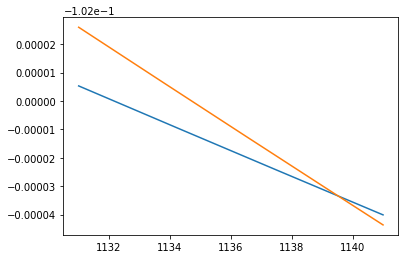

In [115]:

plot_simi_change('friendly', 'unfriendly', original_embed, [708, 641, 204], w2i)

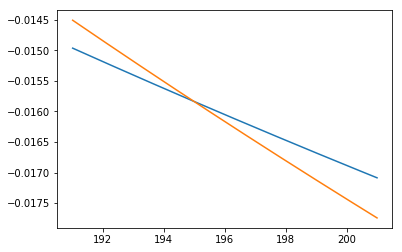

In [113]:
plot_simi_change('friendly', 'unfriendly', original_embed, [708, 641], w2i)

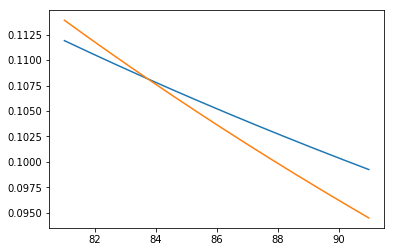

In [116]:
plot_simi_change('friendly', 'unfriendly', original_embed, [708], w2i)

In [43]:
(sum(original_embed[w2i['friendly']]))

-2.0980321876476062

In [55]:
# most_similar(embed, i2w, vec, k=10, except_dim=[]):
most_similar(original_embed, i2w, w2i["friendly"], except_dim=[708, 641, 204, 1206, 1254, 873, 183, 354, 1019, 487, 339, 176, 880, 674, 527, 1120, 229, 939, 184, 215, 1109, 559, 694, 1189, 703, 406, 800, 919, 661, 451, 704, 224, 1247, 330, 262, 608, 706, 357, 601, 1023, 1034, 270, 933, 475, 459, 428, 686, 1267, 92, 364, 359, 801, 978, 322, 522, 665, 897, 1138, 508, 1207, 640, 762, 979, 496, 432, 793, 49, 153, 1040, 61, 1149, 321, 989, 63, 782, 613, 980, 35, 842, 761, 250, 244, 148, 387, 238, 841, 119, 248, 1050, 316, 764, 1208, 426, 371, 635, 185, 241, 388, 598, 201, 160, 1108, 768, 1021, 650, 625, 115, 1195, 1170, 1070, 1009, 395, 328, 1185, 657, 1184, 65, 9, 1203, 74, 172, 452, 882, 17, 1188, 555, 1095, 965, 548, 1039, 903, 186, 1214, 78, 1026, 1099, 317, 780, 1231, 778, 1011, 963, 108, 894, 594, 865, 914, 805, 59, 190, 293, 1200, 561, 286, 744, 977, 1235, 36, 419, 563, 377, 1156, 97, 832, 162, 692, 243, 902, 958, 360, 1006, 923, 1072, 143, 289, 7, 217, 1118, 513, 232, 8, 303, 1044, 1146, 505, 604, 10, 219, 265, 656, 216, 982, 446, 1061, 1016, 1168, 825, 179, 41, 668])

[('friendly', 0.7649003448860365),
 ('unfriendly', 0.5096488956604908),
 ('freindly', 0.41524312201216435),
 ('environmentally', 0.40814391980801695),
 ('helpful', 0.3831378682577776),
 ('affable', 0.37047150339152746),
 ('friendlier', 0.3599604413110357),
 ('welcoming', 0.35710021790845814),
 ('eco', 0.3488996547450603),
 ('courteous', 0.33313196236478976)]

In [7]:
def showKeywordsKeysenses(args, w2i, i2w, cls, texts, test_set, model_args, model, 
                  input_index=0, label=0, 
                  methods=[], 
                  topKWords=10, 
                  topKDims=5, 
                  embeddings=''):
    keywords={}
    keyglobalsenses={}
    for m in methods:
        result = compute_grads(args, w2i, i2w, cls, texts, test_set, model_args, model, 
                  input_index=input_index, label=label, 
                  method=m, 
                  topKWords=10, 
                  topKDims=5, 
                  embeddings='')
        keywords[m] = [s.split("_")[0] for s in (list(result.keys())[5:])]
        
        keyglobalsenses[m]=[a for a,b in (result['Top-Dims'][:10])]
        
    return (keywords, keyglobalsenses)

In [18]:
def setIntersectionPart(s1, s2):
    return float(len(s1.intersection(s2))) / len(s1.union(s2))

In [6]:
# methods = ['InputXGrad','Integrated-Gradient', 'Grad-Cam']
# file_saved_words = "./intersection_words1-3k.txt"
# file_saved_dims = "./intersection_dims1-3k.txt"

# fw = open(file_saved_words, "w")
# fd = open(file_saved_dims, "w")
# fw.write("%s\t%s\t%s\t%s\n"%('idx','ixg.ig','ixg.gradcam', 'ig.gradcam'))
# fd.write("%s\t%s\t%s\t%s\n"%('idx','ixg.ig','ixg.gradcam', 'ig.gradcam'))
# for i in range(1000,3000):
#     words, senses = showKeywordsKeysenses(args, w2i, i2w, cls, texts, test_set, model_args, model, 
#                        input_index=i, label=test_set[i][1], methods=methods, topKWords=20, embeddings='')
#     mat_words = np.zeros((3,3))
#     mat_dims = np.zeros((3,3))
#     for a in range(3):
#         for b in range(3):
#             if a != b:
#                 mat_words[a][b] = round(setIntersectionPart(set(words[methods[a]]), set(words[methods[b]])),2)
#                 mat_dims[a][b] = round(setIntersectionPart(set(senses[methods[a]]), set(senses[methods[b]])),2)
#     fw.write("%s\t%s\t%s\t%s\n"%(i,mat_words[0][1], mat_words[0][2], mat_words[1][2]))
#     fd.write("%s\t%s\t%s\t%s\n"%(i,mat_dims[0][1], mat_dims[0][2], mat_dims[1][2]))
# fw.close()
# fd.close()
# #     print(methods)
# #     print(mat_senses)
# #     print(mat_words)

In [4]:
def getAntonymEmbeds(word, antonym_dict, embed, w2i):
    embeddings = {}
    antonyms = antonym_dict.get(word, None)
    if not antonyms:
        return {}
    else:
        antonyms_list = antonyms.split()
        for a in antonyms_list:
            if w2i.get(a):
                embeddings[a] = embed[w2i[a]]
    return embeddings
    

In [5]:
# show the most simi words in embed reversing the given dim
def most_similar(embed, i2w, word_idx, k=10, except_dim=[], counter=-1, weighted=[]):
    
    k_best = []
    new_embed = embed.copy()
    old_vec = embed[word_idx]
    vec = new_embed[word_idx]
    if not weighted:
        weighted = np.ones(len(weighted))
        
    if except_dim:
        for d in except_dim:
            vec[d] = vec[d] * counter * np.exp(weighted[d]/1000)
#             for i in range(len(embed)):
#                 new_embed[i][d] = 0.0

            
    vec_norm = np.linalg.norm(vec)
    # append the word it self
    k_best.append((word_idx, 
                   np.dot(vec, old_vec) / np.linalg.norm(vec) / np.linalg.norm(old_vec)))
    
    for i in range(1, len(new_embed)):
        if i != word_idx:
            simi = np.dot(vec, new_embed[i]) / np.linalg.norm(new_embed[i]) / vec_norm
            if len(k_best) < k:
                k_best.append((i, simi))
                k_best = sorted(k_best, key=lambda x:x[1], reverse=True)
            elif simi > k_best[-1][1]:
                k_best[-1] = (i, simi)
                k_best = sorted(k_best, key=lambda x:x[1], reverse=True)
    return [(i2w[a],b) for a,b in k_best]

In [6]:
# # new embed = old embed - projection of old embed on antonym direction
# def direction_trans(embed, direct_vector, c=1.0):
#     new_embed = embed.copy()
#     projection = np.asarray(np.matmul(embed, np.matrix(direct_vector).T).T)[0]
#     print(projection.shape)
#     for i in range(embed.shape[0]):
#         v = embed[i] - projection[i] * c
#         new_embed[i] = v
#     return new_embed

In [7]:
# load the config get the model and the data
def init(config_path):
    print('Read config file %s.'%config_path)
    args = readConfig.readConfig(config_path)
    print(args)
    # load embeddings
    embed_matrix = pickle.load(open(args['embed_path']+'/embed.pkl', 'rb'))
    print("Load embedding of size %s"%embed_matrix.shape[1])
    w2i = pickle.load(open(args['w2i']+'/w2i.pkl', 'rb'))
    i2w = pickle.load(open(args['i2w']+'/i2w.pkl', 'rb'))
    # load data
    cls, texts =preprocess.readData(args['input_path']+"/test_classes.data", args['input_path']+"/test_texts.data") 
    test_set = dataset.TextDataset(texts, cls, w2i, int(args['max_sen_len']))
    model = None
    
    model_args = {
        'vocab_size': embed_matrix.shape[0], # add unkown word
        'max_len': int(args['max_sen_len']),
        'n_class': int(args['num_class']),
        'dim': embed_matrix.shape[1],
        'dropout': float(args['dropout']),
        'freeze': True,
        'kernel_num': int(args['channel_size']),
        'embedding_matrix': embed_matrix,
        'forward_embed': True
        
    }
    if args['model']=='shallowCNN':
            print("Start training shallowCNN")
            model = ShallowCNN.ShallowCNN(model_args)
    else:
        model = DPCNN.DPCNN(model_args)
    model.load(args['load_model_from'])
    print(model.eval)
    model.setDropout(0)
    
    return (args, w2i, i2w, cls, texts, test_set, model_args, model)

In [8]:
args, w2i, i2w, cls, texts, test_set, model_args, model = init("../../train/abspath_train_config")

Read config file ../../train/abspath_train_config.
{'action': 'test', 'model': 'DPCNN', 'max_sen_len': '129', 'num_class': '2', 'epoch': '4', 'cv': '0', 'dropout': '0.5', 'freeze': 'True', 'output_path': '/home/sj/Documents/lecture_projects/master_thesis_2020/explain_cnn_text_classifiers/data/models/yelp_polarity_DPCNN/', 'input_path': '/home/sj/Documents/lecture_projects/master_thesis_2020/explain_cnn_text_classifiers/data/datasets/yelp_polarity', 'channel_size': '20', 'embed_path': '/home/sj/Documents/lecture_projects/master_thesis_2020/explain_cnn_text_classifiers/data/embeddings/polar/selected1275_yelp', 'w2i': '/home/sj/Documents/lecture_projects/master_thesis_2020/explain_cnn_text_classifiers/data/embeddings/glove/yelp_polarity', 'i2w': '/home/sj/Documents/lecture_projects/master_thesis_2020/explain_cnn_text_classifiers/data/embeddings/glove/yelp_polarity', 'load_model_from': '/home/sj/Documents/lecture_projects/master_thesis_2020/explain_cnn_text_classifiers/data/models/yelp_pol

In [9]:
def mat_elem_devide(a, b):
    assert a.shape == b.shape
    c = np.zeros(a.shape)
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            if b[i][j] == 0.0:
                c[i][j] = 0.0
            else:
                c[i][j] = a[i][j] / b[i][j]
    return c

In [10]:
model.conv3

Conv2d(20, 20, kernel_size=(3, 1), stride=(1, 1))

In [11]:
def compute_grads(args, w2i, i2w, cls, texts, test_set, model_args, model, 
                  input_index=0, label=0, 
                  method="Integrated-Gradient", 
                  topKWords=20, 
                  topKDims=5, 
                  embeddings=''):
        
    p = input_index
    model.forwardEmbedLayer = False
    num_rows = min(129, len(texts[p]))
    

    input = test_set[p][0]
    label = label#test_set[p][1]
    input = embeddings(input) if embeddings else model.embedding_layer(input)
    input = input.view(1, 1, model_args['max_len'], model_args['dim'])
    out = model(input)
    predicted = torch.argmax(out, dim=1).tolist()[0]
    output_scores = (out[0].detach().numpy())
    attributions_out = None
    # methods return grads
    if method=="Integrated-Gradient":
        print(method)
        ig = IntegratedGradients(model)
        baseline = torch.zeros((model_args['max_len'],model_args['dim']))
        baseline = baseline.view(1, 1, model_args['max_len'], model_args['dim'])
        attributions_out, delta = ig.attribute(input, baseline, target=label, return_convergence_delta=True)
    elif method=="InputXGrad":
        print(method)
        attributions_out = input_x_gradient.InputXGradient(model).attribute(input, target=label)
    elif method=="Grad-Cam":
        print(method)
        # does not work
#         layer_grad_cam = grad_cam.LayerGradCam(model, model.layers[4].conv2)
#         attributions_out = layer_grad_cam.attribute(input, target=label)
        attributions_out = guided_grad_cam.GuidedGradCam(model, model.conv3).attribute(input, target=label)
    elif method == "DeepLift":
        print(method)
        mlmodel = model.toMLCNN(5)
        mlmodel.forwardEmbedLayer = False
        attributions_out = DeepLift(mlmodel).attribute(input, target=label)
        del mlmodel
        print(attributions_out.shape)
    elif method=="LIME-Word":
        print(method)
        ks = kernel_shap.KernelShap(model)
        feature_mask = np.zeros((model_args['max_len'],model_args['dim']))
        for i in range(1,model_args['max_len']):
            feature_mask[i] = np.ones(model_args['dim']) * i
        feature_mask = torch.LongTensor(feature_mask).view(1, 1, model_args['max_len'], model_args['dim'])
        attributions_out = ks.attribute(input, target=label, n_perturb_samples=5000, feature_mask=feature_mask)
        
#         shap = gradient_shap.GradientShap(model)
#         baseline = torch.zeros((model_args['max_len'],model_args['dim']))
#         baseline = baseline.view(1, 1, model_args['max_len'], model_args['dim'])
#         num_samples = 500
#         attributions_out, delta = shap.attribute(input, baseline, n_samples=num_samples, target=label, return_convergence_delta=True)
    
    elif method == "Saliency":
        print(method)
        attributions_out = Saliency(model).attribute(input, target=label, abs=True)
        
    else:
        print("Unkown method name, return outputs.")
        print(method)
#         print(input.view(model_args['max_len'], model_args['dim']).detach().numpy())
#         return output_scores

    attributions = attributions_out.view(model_args['max_len'], model_args['dim']).detach().numpy()
    _input = input.view(model_args['max_len'], model_args['dim']).detach().numpy()
#     attributions = (mat_elem_devide(attributions, _input))

    # flaten
    flat_attribution = attributions.reshape((model_args['max_len'] * model_args['dim'], ))
    flat_attribution = stats.zscore(flat_attribution, ddof=1)

    # check top K contributing words
    K = min(topKWords,len(texts[p]))
    num_top_dims = topKDims
    # sort by sum
    word_contributions = [(i, np.sum(attributions[i])) for i in range(num_rows) ]
    word_contributions = sorted(word_contributions, key=lambda x: x[1], reverse=True)
    topk_words = [i for i,v in word_contributions[:K]]
    dict_ranks = {}
    for i in range(K):
        dict_ranks[topk_words[i]] = i
        
    # check over all top contribution dims
    dim_contributions = [(i, np.sum(column)) for i, column in enumerate(attributions.T)]
    dim_contributions = sorted(dim_contributions, key=lambda x:x[1], reverse=True)
        


    # load dim names
    antonym_names = [b for a,b in pickle.load(open(args['load_dim_names'], 'rb'))]
    # build sorted list of attributions
    flat_attr_sorted = []
    # remember position in flat attribution list
    pos_counter = 0 
    word_counter = {}
            
    for i in range(num_rows):
        w = texts[p][i]
        word_counter[w] = word_counter.get(w, 0) + 1
        # print(pos_counter / model_args['dim'])
        row = flat_attribution[pos_counter: pos_counter+model_args['dim']]
        temp_list = []
        if i in topk_words:
            for t in range(model_args['dim']):
                attr_value = row[t]
                a1 = antonym_names[t][0]
                a2 = antonym_names[t][1]
                w_contrib = dict(word_contributions)[i]
                word_pair = (a1,a2) #if attr_value < 0 else (a2,a1)
                temp_list.append( (w, word_counter[w], word_pair, abs(attr_value), dict_ranks[i], w_contrib))

#             temp_list = sorted(temp_list, key=lambda x: x[3], reverse=True)
            
            flat_attr_sorted.append(temp_list)
        pos_counter += model_args['dim']
            
    # construct dict as output
    dict_to_json = {
                'Text' : text_sentences[p],
                'Prediction' : 'Positive' if predicted > 0 else 'Negative',
                'True-Label' : 'Positive' if test_set[p][1] > 0 else 'Negative',
                'Out' : [round(output_scores[0],6), round(output_scores[1], 6)],
                'Top-Dims':[(antonym_names[i], v) for i,v in dim_contributions]
                
            }
    
    for index in range(len(flat_attr_sorted)):
        word_dict = {}
        antonym_dict = {}
        for w, wc, antonym_pair, v, rank, contrib in flat_attr_sorted[index]:
            if not word_dict:
                word_dict['Word'] = w 
                word_dict['Contribution'] = str(word_contributions[topk_words[index]][1])
                word_dict["Rank"] = rank
                word_dict["Contribution"] = contrib
                # [sentence_index, word_index in the sentence]
                pos = [0,0]
                # here I want to find the position of the word in the original text,
                # not the position in the preprocessed input text where stop words are removed, 
                # so it will be messy here
                for sent_index in range(len(text_sentences[p])):
                    pos[0] = sent_index
                    words = text_sentences[p][sent_index].split(' ')
                    for word_index in range(len(words)):
                        pos[1] = word_index
                        if words[word_index].lower() == w.lower():
                            wc -= 1
                            # print(word, type(wc), type(pos[1]))
                            if wc == 0:
                                # print(word)
                                word_dict['Position'] = pos
                                break
                    if word_dict.get('Position'):
                        break

            antonym_dict[antonym_pair[0]+','+ antonym_pair[1]] = v
            antonym_dict = dict(sorted(antonym_dict.items(), key=lambda x:x[1], reverse=True))
        word_dict['Antonyms'] = antonym_dict
        dict_to_json[word_dict['Word']+"_"+str(index)] = word_dict
        
    return dict_to_json

In [12]:
# antonym_dim_names = dict([(b,a) for a,b in pickle.load(open(args['load_dim_names'], 'rb'))])
# antonym_dim_names

In [13]:
def tuple_swap(t):
#     print(t)
    assert len(t) == 2
    return (t[1], t[0],)

In [16]:
def get_input_cells(embed, words, dims, dim_name_dict, w2i):
    cell_matrix = np.zeros((len(words),len(dims)))
    cell_position = {}
    for w_idx in range(len(words)):
        for d_idx in range(len(dims)):
            column_idx_in_embed = dim_name_dict.get(dims[d_idx], None)
            if not column_idx_in_embed:
                column_idx_in_embed = dim_name_dict[tuple_swap(dims[d_idx])]
                
            cell_matrix[w_idx][d_idx] = embed[w2i[words[w_idx]]][column_idx_in_embed]
            cell_position[(w_idx, d_idx)] = (w2i[words[w_idx]], column_idx_in_embed)
    return (cell_matrix, cell_position)

In [17]:
def set_input_cells(new_values, embed, positions):
    for w_idx in range(new_values.shape[0]):
        for d_idx in range(new_values.shape[1]):
            (row_idx, col_idx) = positions[(w_idx, d_idx)]
            embed[row_idx][col_idx] = new_values[w_idx][d_idx]
    return embed

In [18]:
# set dim to zero
def set_dim_zero(dim_name, dim_dict, embed):
    for row in embed:
        row[dim_dict[dim_name]] = 0.0
    

In [19]:
# embed_set = set_input_cells(new_v, embed=np.asarray(model_args['embedding_matrix']), positions=ppos)
# get_input_cells(embed_set, ['mike', 'eat', 'good'], 
#               [('appoint', 'elect'),
#                  ('abroad', 'home'),
#                  ('coda','overture'),
#                  ('hawk', 'dove')], antonym_dim_names, w2i)

### use ipython widgets to build a simple UI

In [20]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout, GridBox, Button, ButtonStyle, Box



In [21]:
def get_word_contr_progress(v, vmin=0, vmax=0.6, step=0.05):
    value = np.log(v+1)
    return widgets.FloatProgress(
        value=np.abs(value),
        min=vmin,
        max=vmax,
        step=step,
        description='',
        disabled=True,
        bar_style = 'info' if value > 0 else 'danger',
        continuous_update=False,
        orientation='vertical',
        readout=False,
        layout={'height': '50px'}
    )

In [22]:
np.log(1.8)

0.5877866649021191

In [23]:
# # HTML of input sentences
# def get_sentences(sentences, words, grad_dict):
    
#     layout = Layout(display='space-between',
#                     flex_flow='row wrap',
#                     align_items='flex-start',
#                     border='solid 1px orange',
#                     width='auto')
#     output_sentences = []
#     for idx_sent in range(len(sentences)):
#         words_in_s = sentences[idx_sent].split()
#         for w in words:
#             if 'Position' in grad_dict[w] and grad_dict[w]['Position'][0] == idx_sent:
                
#                 if grad_dict[w]["Rank"] < 3:
#                     words_in_s[grad_dict[w]['Position'][1]] = "<split><Button><top>" + w + "<split>"
#                 else:
#                     words_in_s[grad_dict[w]['Position'][1]] = "<split><Button>" + w + "<split>"
#         new_sent = " ".join(words_in_s).split("<split>")
#         output_sentences.append(new_sent)
        
#     boxes = []
#     for s in output_sentences:
#         items = []
#         hbox = widgets.HBox()
#         for sent_seg in s:
#             # To do change color with rank
#             if sent_seg.startswith("<Button><top>"):
#                 items.append(widgets.Button(description=sent_seg[13:],
#                  layout=Layout(width= 'auto', border='solid 1px red'),
#                  style=ButtonStyle(button_color='white')))
#                 items.append(get_word_contr_progress(v=grad_dict[sent_seg[13:]]))
#             elif sent_seg.startswith("<Button>"):
#                 items.append(widgets.Button(description=sent_seg[8:],
#                  layout=Layout(width= 'auto', border='solid 1px green'),
#                  style=ButtonStyle(button_color='white')))
#             else:
#                 items.append(widgets.HTML(value = sent_seg, layout = Layout(display='space-between',
#                     flex_flow='column',
#                     align_items='stretch',
# #                     border='solid 1px orange',
#                     width='auto')))
#         hbox.children = items
#         hbox.layout = layout
#         boxes.append(hbox)
        
        
#     vbox = widgets.VBox()
#     vbox.layout.align_items = 'flex-start'
#     vbox.children = boxes
#     vbox.layout.flex_flow = "flex-wrap"
        
#     return vbox
        

In [24]:
# sentences = [widgets.HTML(value = js_data['Text'][i],
#                  layout=Layout(height = 'auto',  grid_area='footer'+str(i+1)+'l')) for i in range(len(js_data["Text"][:2]))]

In [25]:
def get_progress_bar(name, value, vmin=0, vmax=10, step=0.1):    
    dim_value = widgets.HTML(value = "<b>  "+ str(round(float(value),2))+" </b>", layout=Layout(width='auto', grid_area='h3'),)
    dim_name = widgets.HTML(value = "<b>  "+ str(name)+" </b> \t", layout=Layout(width='auto', grid_area='h1'),)
    
    bar = widgets.FloatProgress(
        value=value,
        min=vmin,
        max=vmax,
        step=step,
        description="",
        bar_style='info',
        orientation='horizontal',
        layout=Layout(width='auto', grid_area='h2', ),
    )
#     hbox.children = [dim_name, bar, dim_value]
    gbox = GridBox(children=[dim_name, bar, dim_value],
            layout=Layout(
                width='100%',
                grid_template_rows='auto auto',
                grid_template_columns='70% 30%',
                grid_template_areas='''
                "h1 h1"
                "h2 h3"
                ''')
           )
    return gbox

In [26]:

widgets.FloatRangeSlider(
    value=[5, 7.5],
    min=0,
    max=10.0,
    step=0.1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='vertical',
    readout=False,
    slider_color='2',
    color='bl42',
    layout={'height': '60px'}
)

FloatRangeSlider(value=(5.0, 7.5), continuous_update=False, description='Test:', layout=Layout(height='60px'),…

In [27]:
# input grad of a word
def get_grad_bars(grad_dict, num_dims=5):
    len_min = min(num_dims, len(grad_dict))
    bar_list = [get_progress_bar("["+str(i+1)+"]: "+w, grad_dict[w], vmin=0, vmax=70, step=2.0) for i,w in enumerate(grad_dict) if i<len_min]
    bar_layout = Layout( width='auto')
    box_layout = Layout(display='flex-end',
                        flex_flow='column',
                        align_items='center',
    #                     border='solid',
                        width='100%')
    box = Box(children=bar_list, layout=box_layout)
    ad_box = widgets.VBox()
    ad_box.layout.align_items = 'center'
    ad_box.children = [box]
    return box
#     ad_box.layout = Layout(width='auto', grid_area='footerr')


In [28]:
def get_grad_box(json_data, keyword, num_dims=5):
    box = get_grad_bars(json_data[keyword]['Antonyms'], num_dims)
    grads_box = widgets.VBox()
    grads_box.layout.align_items = 'center'
    grads_box.children = [box]
    grads_box.layout = Layout(width='auto', grid_area='footerr')
    return grads_box

In [29]:
from IPython.display import clear_output


In [30]:
# compute_grads(args, w2i, i2w, cls, texts, test_set, model_args, model, input_index=120, label=0, method="Integrated-Gradient")

In [31]:
def background_calculation(args, w2i, i2w, cls, texts, test_set, model_args, model, new_embed,
             input_index=120, label=0, method="Integrated-Gradient"):
    
    view = get_view(args, w2i, i2w, cls, texts, test_set, model_args, model, new_embed,
             input_index=120, label=0, method="Integrated-Gradient")
    time.sleep(3)
    display(view)
#     # when the calculation is done, the result is stored in a global variable
#     global global_view
#     global_view = view


In [32]:
# getAntonymEmbeds('terrible', all_antonyms, original_embed, w2i)

In [33]:
def get_embed_set_view(length = 5):
    set_bt = Button(description='Set embedding',
                         layout=Layout(width='auto', grid_area='c1'),
                         style=ButtonStyle(button_color='lightblue'))
    back_bt = Button(description='Default values',
                         layout=Layout(width='auto', grid_area='c2'),
                         style=ButtonStyle(button_color='lightblue'))
    dim_bt = Button(description='Remove dimension',
                         layout=Layout(width='auto', grid_area='c3'),
                         style=ButtonStyle(button_color='lightblue'))

    # 5 Vboxes
    dim_value_boxes = [ widgets.VBox(children=[Button(description="["+str(i+1)+"]",
                                                 layout=Layout(width='auto'),
                                                 style=ButtonStyle(button_color='white')),
                                               widgets.Text(value="0.0", 
                                                            layout=Layout(flex_flow="center",
                                                                          width='auto'))
                                              ],
                                     layout = Layout(width='auto', 
                                                   grid_area = 'a'+str(i+1))) 
                       for i in range(length) ]
    # add actions to dim buttons
    for box in dim_value_boxes:
        def change_color_on_click(sender):
            sender.style.button_color='orange' if sender.style.button_color=='white' else 'white'
        box.children[0].on_click(change_color_on_click)
            

    test_btn=widgets.Button(description='Test',layout=Layout(width='auto', grid_area='c5'),
                         style=ButtonStyle(button_color='lightblue'))

    embed_gridbox = GridBox(children=dim_value_boxes + 
                                     [dim_bt,test_btn, set_bt, back_bt],
                layout=Layout(
                    width='100%',
                    grid_template_rows='auto auto auto',
                    grid_template_columns='20% 20% 20% 20% 20%',
                    grid_template_areas='''
                    "a1 a2 a3 a4 a5"
                    "b1 b2 b2 b2 b2"
                    "c1 c2 c3 c4 c5"
                    ''')
               )
    return embed_gridbox

In [34]:
# get_view(args, w2i, i2w, cls, texts, test_set, model_args, model, to__temp=new_embed, input_index=24, label=0, method="Integrated-Gradient", display_view=True)

In [35]:

# new_embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(model_args['embedding_matrix'].copy()), freeze = True)
# original_embed = np.asarray(model_args['embedding_matrix'].copy())
# new_embed = np.asarray(model_args['embedding_matrix']).copy()

In [36]:
# HTML of input sentences
def get_sentences_2(sentences, words, grad_dict, k=3):#, antonym_dict, w2i):
    
    layout = Layout(display='space-between',
                    flex_flow='row wrap',
                    align_items='flex-start',
                    border='solid 1px orange',
                    width='auto')
    output_sentences = []
    contr_min = 1000.0
    contr_max = -1000.0
    for idx_sent in range(len(sentences)):
        words_in_s = sentences[idx_sent].split()
        for w in words:
            contr = grad_dict[w]['Contribution']
            contr_max = max(contr, contr_max)
            contr_min = min(contr, contr_min)
            if 'Position' in grad_dict[w] and grad_dict[w]['Position'][0] == idx_sent:
                
                if grad_dict[w]["Rank"] < k:
                    words_in_s[grad_dict[w]['Position'][1]] = "<split><Button><top>" + w + "<split>"
                else:
                    words_in_s[grad_dict[w]['Position'][1]] = "<split><Button>" + w + "<split>"
        new_sent = " ".join(words_in_s).split("<split>")
        output_sentences.append(new_sent)
        
    
        
    boxes = []
    for s in output_sentences:
        items = []
        hbox = widgets.HBox()
        for sent_seg in s:
            # To do change color with rank
            if sent_seg.startswith("<Button><top>"):
                items.append(
                    widgets.VBox(children=[ get_word_contr_progress(v=grad_dict[sent_seg[13:]]['Contribution'], vmax=np.log(1+contr_max), vmin=np.log(1+contr_min)),
                                            widgets.Button(description=sent_seg[13:],
                                             layout=Layout(width= 'auto'),
                                             style=ButtonStyle(button_color='white')),
                                           widgets.Dropdown(
                                            options=[('1', 1), ('2', 2), ('3', 3)],
                                            value=1,
                                            description='',
                                            layout=Layout(width='auto', align_items='flex-start'))
                                          ],
                                     layout = Layout(width='auto', 
                                                     border='solid 1px red'))
                )
            elif sent_seg.startswith("<Button>"):
                items.append(
                    widgets.VBox(children=[get_word_contr_progress(v=grad_dict[sent_seg[8:]]['Contribution'], vmax=np.log(1+contr_max), vmin=np.log(1+contr_min)),
                                            widgets.Button(description=sent_seg[8:],
                                             layout=Layout(width= 'auto'),
                                             style=ButtonStyle(button_color='white')),
                                           widgets.Dropdown(
                                            options=[('1', 1), ('2', 2), ('3', 3)],
                                            value=1,
                                            description='',
                                            layout=Layout(width='auto', align_items='flex-start'))
                                          ],
                                     layout = Layout(width='auto', 
                                                     border='solid 1px green'))
                )
            else:
                items.append(widgets.HTML(value = sent_seg, layout = Layout(display='space-between',
                    flex_flow='column',
                    align_items='stretch',
#                     border='solid 1px orange',
                    width='auto')))
        hbox.children = items
        hbox.layout = layout
        boxes.append(hbox)
        
        
    vbox = widgets.VBox()
    vbox.layout.align_items = 'flex-start'
    vbox.children = boxes
    vbox.layout.flex_flow = "flex-wrap"
        
    return vbox
        

## ===========================

In [37]:
def get_top_dims_HTML(dims, k=5):
    s = ""
    for t,v  in dims[:5]:
        s = s + "<p>" +t[0] + ", "+ t[1] + "</p>"
    return s

In [38]:
from wordcloud import WordCloud

In [39]:
def get_wordcloud(word, grad_dict, embed, dim_name_dict, w2i):
    d = {}
    for dim_name in grad_dict:
        dim_name_old = tuple(dim_name.split(","))
        embed_value = get_input_cells(embed, [word], [dim_name_old], dim_name_dict, w2i)[0][0]
        polars = dim_name.split(",")
        dim_name_new = polars[0] if embed_value>=0 else polars[1]
        d[dim_name_new] = grad_dict[dim_name]
    wordcloud = WordCloud(width=900,height=500, max_words=20,relative_scaling=1,normalize_plurals=False, background_color="white").generate_from_frequencies(d)
    
    plt.axis("off")
    plt.title('Wordcloud of '+word)
    return plt.imshow(wordcloud, interpolation='bilinear')

In [40]:
# dim_names = dict([(b,a) for a,b in pickle.load(open(args['load_dim_names'], 'rb'))])
# get_wordcloud('terrible', js_data['terrible_3']['Antonyms'], original_embed, dim_names, w2i)

In [41]:
def get_view_2(args, w2i, i2w, cls, texts, test_set, model_args, model, to__temp,
             input_index=120, label=0, method="Integrated-Gradient", display_wc=False):
    global new_embed_layer
    global original_embed
    global new_embed
    global all_antonyms
    global dim_question_threshold
    global text_sentences
    global max_num_flip_dim
    global reverse_constant
    
    dim_names = dict([(b,a) for a,b in pickle.load(open(args['load_dim_names'], 'rb'))])
    num_dims_display = 5
    js_data = compute_grads(args, w2i, i2w, cls, texts, test_set, model_args, model, 
                       input_index=input_index, label=label, method=method, embeddings=new_embed_layer)
    key_words = list(js_data.keys())[5:]
    init_word = key_words[0]
    init_dims = list(js_data[init_word]['Antonyms'].keys())
    init_word_antonyms = getAntonymEmbeds(init_word.split('_')[0], all_antonyms, original_embed, w2i)
#     new_embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(new_embed), freeze  = True)
    
    method_drpb=widgets.Dropdown(
        options=[('Integrated-Gradient', 1), ('Grad-Cam', 2), ('InputXGrad', 3), ('LIME-Word', 4), ('DeepLift', 5), ('Saliency',6)],
        value=dict([('Integrated-Gradient', 1), ('Grad-Cam', 2), ('InputXGrad', 3), ('LIME-Word', 4), ('DeepLift', 5), ('Saliency',6)])[method],
        description='Method:',
        layout=Layout(width='auto', grid_area='a2', align_items='flex-start'),
    )


    model_outs = widgets.VBox()
    model_outs.layout = Layout(display='space-between',
                    align_items='flex-start',
#                     border='solid',
                    width='auto',
                    grid_area='b1')
    model_outs.children = [widgets.Button(description="Expected: "+ js_data["True-Label"],
                                          layout=Layout(width='auto',align_items='flex-start'),
                                         style=ButtonStyle(button_color='orange')),
                           
                           widgets.Button(description="Positive: "+ str(js_data["Out"][1]), 
                                          layout = Layout(align_items='flex-start',width='auto')),
                           
                           widgets.Button(description="Negative: "+str(js_data["Out"][0]), 
                                        layout = Layout(align_items='flex-start',width='auto'))]
    
    index_text = widgets.Text(value=str(input_index), description='Input index:',
                             layout=Layout(width='80%', grid_area='a1', align_items='flex-start'))
    overall_top_dims_text = widgets.HTML(value=get_top_dims_HTML(js_data["Top-Dims"], num_dims_display), 
                                         description='',
                                         layout=Layout(width='auto', grid_area='topdim', align_items='flex-start',
                                         border='solid 1px orange'))
    view_outputs = widgets.VBox()
    view_outputs.layout =  Layout(display='space-between',
                    align_items='flex-start',
                    border='solid 1px orange',
                    width='auto',
                    grid_area='outs')
    view_outputs.children = [widgets.HTML(value="%s rank %s with score %s"%(key_words[0], 
                                                                            js_data[key_words[0]]["Rank"]+1,
                                                                            js_data[key_words[0]]["Contribution"]), 
                                         description='',
                                          width='auto'
                                         )
                            ]
    output_clear_btn = Button(description="Clear output", 
                              layout = Layout(width="auto", grid_area="clear"))
    generate_questions_btn = Button(description="Generate test questions", 
                              layout = Layout(width="auto", grid_area="gen"))


    class_drpb = widgets.RadioButtons(
        options=['Positive', 'Negative'],
        value="Positive" if label == 1 else "Negative",
        description='Class:',
        layout=Layout(width='auto', grid_area='a3'),
    )


    submit_bt = Button(description='Fetch',
                     layout=Layout(width='auto', grid_area='a4'),
                     style=ButtonStyle(button_color='lightblue'))

    column_left  = Button(description='Sentences',
                     layout=Layout(width='auto', grid_area='hl'),
                     style=ButtonStyle(button_color='moccasin'))
    column_right  = Button(description=init_word,
                     layout=Layout(width='auto', grid_area='hr'),
                     style=ButtonStyle(button_color='orange'))
    
#     wordcloud output
    wordcloud_out = widgets.Output(layout=Layout(width='auto', grid_area='wc'))
    if display_wc:
        with wordcloud_out:
            get_wordcloud(init_word.split("_")[0], js_data[init_word]['Antonyms'], original_embed, dim_names, w2i)
    


    sentences = get_sentences_2(js_data['Text'], key_words, js_data, k=5)
    sentences.layout = Layout(width='auto', grid_area='footerl', flex_flow = "flex-wrap")
    
    #embed set view
    embed_box = get_embed_set_view()
    embed_box.layout.grid_area='b2'
    embed_values, embed_positions = get_input_cells(new_embed, words=[init_word.split('_')[0]], 
                                                    dims=[tuple(v.split(",")) for v in init_dims], 
                                                    dim_name_dict=dim_names, w2i=w2i)

    ddbox = GridBox(children=[class_drpb, method_drpb, index_text, submit_bt,model_outs,
                               generate_questions_btn, output_clear_btn,
                              overall_top_dims_text, view_outputs,
                              wordcloud_out,column_left, column_right, sentences,
                              embed_box,
                              get_grad_box(js_data, init_word, num_dims=num_dims_display)
                              ],
            layout=Layout(
                width='100%',
                grid_template_rows='auto auto auto',
                grid_template_columns='30% 30% 20% 20%',
                grid_template_areas='''
                "a1 a2 a3 a4"
                "b1 b2 b2 b2"
                "topdim outs outs outs"
                "_ _ gen clear"
                "hl hl hr hr"
                "ml ml mr mr "
                "wc wc wc wc"
                "footerl footerl footerr footerr"
                "footerl footerl footerr footerr"
                "footerl footerl footerr footerr"
                "footerl footerl footerr footerr"
                "footerl footerl footerr footerr"
                ''')
           )
    
    # reload the view when click button fetch
    def action_fetch(sender):
        clear_output(wait=True)
        new_index = int(index_text.value)
        new_label = 1 if class_drpb.value == "Positive" else 0
        new_method = dict([(1, 'Integrated-Gradient'), (2, 'Grad-Cam'), (3, 'InputXGrad'), (4, 'LIME-Word'), (5, 'DeepLift'), (6, 'Saliency')])[method_drpb.value]
        get_view_2(args, w2i, i2w, cls, texts, test_set, model_args, model, 
                             to__temp = new_embed,
                            input_index=new_index, label=new_label, method=new_method, display_wc=display_wc)
    submit_bt.on_click(action_fetch)
    
    # clear outputs when click button clear
    def action_clear_outputs(sender):
        ddbox.children[-7].children = [widgets.HTML(value=">:")]
    output_clear_btn.on_click(action_clear_outputs)
    
    # generate questions to txt files
    def action_generate_questions(sender):
        current_word = column_right.description
        current_dims = []#list(js_data[current_word]['Antonyms'].keys())
        pos = js_data[current_word]["Position"]
        word = current_word.split("_")[0]
        sent = text_sentences[input_index][pos[0]]
        sent = sent.split()
        sent[pos[1]] = "<"+word+">"
        sent = " ".join(sent)
       
        for d_name in js_data[current_word]['Antonyms']:
            if js_data[current_word]['Antonyms'][d_name] > dim_question_threshold:
                dim_name_old = tuple(d_name.split(","))
                embed_value = get_input_cells(original_embed, [word], [dim_name_old], dim_names, w2i)[0][0]
                polars = dim_name_old
#                 dim_name_new = polars[0]+", not "+polars[1] if embed_value>=0 else polars[1]+", not "+polars[0]
                current_dims.append(dim_name_old)
#         print("%s: %s"%(js_data['Prediction'], sent))
#         print(current_word, current_dims[:10])
        except_d = [dim_names[k] for k in current_dims]
        # most_similar(embed, i2w, vec, k=10, except_dim=[]):
        similar_words = most_similar(original_embed, i2w, w2i[word], 
                           except_dim=except_d[:min(max_num_flip_dim, len(except_d))], 
                           counter=reverse_constant,
                           weighted=[js_data[current_word]["Antonyms"][",".join(d)] for d in dim_names])
        print(similar_words)
#         with wordcloud_out:
#             plot_simi_change(word, similar_words[1][0], original_embed, except_d[:min(max_num_flip_dim, len(except_d))], w2i)

        
        ddbox.children[-7].children=  list(ddbox.children[-7].children)+  [widgets.HTML(value="",  
                                                                                        width='auto')]
        
    generate_questions_btn.on_click(action_generate_questions)
    
    
#     change embed value when replacing new words
    def handle_replacing_word(change):
        current_word = column_right.description
        current_dims = list(js_data[current_word]['Antonyms'].keys())
        new_word = [w for w,i in change.owner.options if i==change.new][0] 
        embed_values = np.zeros((1,5))
        if new_word != '_NULL_':
            embed_values, embed_positions = get_input_cells(embed=original_embed, words=[new_word], 
                                                        dims=[tuple(v.split(",")) for v in current_dims], 
                                                        dim_name_dict=dim_names, w2i=w2i)
        for i, child in enumerate(ddbox.children[-2].children):
            if type(child) == widgets.widget_box.VBox:
    #             print(child.children)
                child.children[-1].value = str(round(embed_values[0][i]*1000,2))
       


            
    # init sentences
    for box in sentences.children:
        for child in box.children:
            if type(child) == widgets.widget_box.VBox:
                # add click actions
                def button_action(sender):
                    current_word = sender.description
                    current_dims = list(js_data[current_word]['Antonyms'].keys())
                    column_right.description = current_word
                    # output updates
                    ddbox.children[-7].children=  list(ddbox.children[-7].children)+  [widgets.HTML(value="%s rank %s with score %s"%(current_word, 
                                                                            js_data[current_word]["Rank"]+1,
                                                                            js_data[current_word]["Contribution"]), 
                                         description='',
                                          width='auto'
                                         )]
                    
                    # wordcloud    
                    if display_wc:
                        with wordcloud_out:
                            get_wordcloud(current_word.split("_")[0], js_data[current_word]['Antonyms'], original_embed, dim_names, w2i)

                child.children[1].on_click(button_action)
                # add replaceing words
                word = child.children[1].description.split("_")[0]
                # antonyms
                word_antonyms = getAntonymEmbeds(word, all_antonyms, original_embed, w2i)
                child.children[2].options=[(word,1)] + \
                                          [(w,i+2) for i,w in enumerate(word_antonyms.keys())] + \
                                          [("_NULL_", len(word_antonyms)+2)]
                child.children[2].value = 1
                child.children[2].observe(handle_replacing_word, names="value")

    
    # embed value init
    for i, child in enumerate(embed_box.children):
        if type(child) == widgets.widget_box.VBox:
#             print(child.children)
            child.children[-1].value = str(round(embed_values[0][i]*1000,2))
            child.children[-2].description = init_dims[i].split(",")[0]

    # on click test 
    def repl_test_btn_on_click(sender):
        global new_embed_layer
        word_changes_str = ""
        for box in ddbox.children[-3].children:
            for child in box.children:
                if type(child) == widgets.widget_box.VBox:
                    if child.children[2].value > 1:
                        old_word = child.children[2].options[0][0]
                        new_word = [w for w,i in child.children[2].options if i==child.children[2].value][0]
                        new_embed[w2i[old_word]] = np.zeros(new_embed.shape[1])
                        if new_word != "_NULL_":
                            new_embed[w2i[old_word]] = original_embed[w2i[new_word]]
                        word_changes_str += "%s to %s, "%(old_word, new_word)
                        
                        new_embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(new_embed), freeze  = True)
        new_results = compute_grads(args, w2i, i2w, cls, texts, test_set, model_args, model, 
                        input_index=input_index, label=label, method=method, embeddings=new_embed_layer)
#         ddbox.children = [show_results_text]+list(ddbox.children)
        print("Prediction after replacement:%s, scores negative/positive: %s, %s"\
              %(new_results['Prediction'], new_results['Out'], 100*np.exp(new_results['Out'])))           
        #  view_outputs_text.value 
        ddbox.children[-7].children=  list(ddbox.children[-7].children)+  [widgets.HTML(value="<p>%s</p>%s, scores negative/positive: %s, %s"\
              %(word_changes_str, new_results['Prediction'], new_results['Out'], 100*np.exp(new_results['Out'])),  
                                                                                        width='auto')]
#     print(ddbox.children[-2].children[-3])
    ddbox.children[-2].children[-3].on_click(repl_test_btn_on_click)
    
    
    # on click remove dim 
    def remove_dim_on_click(sender):
        global new_embed_layer
        current_word = column_right.description
        current_dims = list(js_data[current_word]['Antonyms'].keys())[:num_dims_display]
        for i, child in enumerate(ddbox.children[-2].children):
            if type(child) == widgets.widget_box.VBox:
    #             print(child.children)
                if child.children[0].style.button_color == 'orange':
#                     dim_names[]
                    dim = current_dims[i]
                    dim = tuple(dim.split(','))
                    set_dim_zero(dim, dim_names, new_embed)
                    print(new_embed[w2i[current_word.split('_')[0]]][dim_names[dim]])
        # update in view
        embed_values, embed_positions = get_input_cells(embed=new_embed, words=[current_word.split('_')[0]], 
                                                        dims=[tuple(v.split(",")) for v in current_dims], 
                                                        dim_name_dict=dim_names, w2i=w2i)
        for i, child in enumerate(ddbox.children[-2].children):
            if type(child) == widgets.widget_box.VBox:
                child.children[-1].value = str(round(embed_values[0][i]*1000,2))
        new_embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(new_embed), freeze  = True)
    ddbox.children[-2].children[-4].on_click(remove_dim_on_click)
                    
    
    
    
    # change gradient bars when word selected changes
    def handle_word_change(change):
        current_word = change.new
        current_dims = list(js_data[current_word]['Antonyms'].keys())[:num_dims_display]
        # update gradient values
        for box in ddbox.children[-1].children:
            for i, grad_bar in enumerate(box.children):
                dim_name = list(js_data[change.new]['Antonyms'].keys())[i]
                dim_value = js_data[change.new]['Antonyms'][dim_name]
                grad_bar.children[0].value = "<b>["+str(i+1)+"]: "+ str(dim_name) +" </b>"
                grad_bar.children[1].value = dim_value
                grad_bar.children[2].value = "<b>  "+ str(round(float(dim_value),2))+" </b>"

#         print(embed_positions)
        embed_values, embed_positions = get_input_cells(embed=new_embed, words=[current_word.split('_')[0]], 
                                                        dims=[tuple(v.split(",")) for v in current_dims], 
                                                        dim_name_dict=dim_names, w2i=w2i)
        for i, child in enumerate(ddbox.children[-2].children):
            if type(child) == widgets.widget_box.VBox:
    #             print(child.children)
                child.children[-1].value = str(round(embed_values[0][i]*1000,2))
                child.children[-2].description = current_dims[i].split(",")[0]
       
    column_right.observe(handle_word_change, names='description')
    
    
    
    
    # add on click actions for embedding set buttons
    def embed_set_on_click(sender):
        global new_embed_layer
        current_word = column_right.description
        current_dims = list(js_data[current_word]['Antonyms'].keys())[:num_dims_display]
        embed_values, embed_positions = get_input_cells(embed=new_embed, words=[current_word.split('_')[0]], 
                                                        dims=[tuple(v.split(",")) for v in current_dims], 
                                                        dim_name_dict=dim_names, w2i=w2i)
        print("Set up new values.")
        new_embed_value = np.zeros((1, 5))
        for i, child in enumerate(ddbox.children[-2].children):
            if type(child) == widgets.widget_box.VBox:
                new_embed_value[0][i] = float(child.children[-1].value) / 1000
        print(new_embed_value)
        set_input_cells(new_values=new_embed_value, embed=new_embed, positions=embed_positions)
#         for w_idx in range(embed_values.shape[0]):
#             for d_idx in range(embed_values.shape[1]):
#                 (row_idx, col_idx) = embed_positions[(w_idx, d_idx)]
#                 new_embed[row_idx][col_idx] = new_embed_value[w_idx][d_idx]
        new_embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(new_embed), freeze  = True)
    ddbox.children[-2].children[-2].on_click(embed_set_on_click)
    
    # add on click actions for embedding set to default button
    def embed_set_default_on_click(sender):
        global new_embed_layer
        global new_embed
        current_word = column_right.description
        current_dims = list(js_data[current_word]['Antonyms'].keys())[:num_dims_display]
        embed_values, embed_positions = get_input_cells(embed=new_embed, words=[current_word.split('_')[0]], 
                                                        dims=[tuple(v.split(",")) for v in current_dims], 
                                                        dim_name_dict=dim_names, w2i=w2i)
        print("Set to default values.")
        old_embed_value = np.zeros((1, 5))
        for i, t in enumerate(embed_positions.values()):
            old_embed_value[0][i] = original_embed[t[0]][t[1]]
#         set_input_cells(new_values=old_embed_value, embed=new_embed, positions=embed_positions)
#         new_embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(new_embed), freeze  = True)
        # update 
        for i, child in enumerate(ddbox.children[-2].children):
            if type(child) == widgets.widget_box.VBox:
                child.children[-1].value = str(round(old_embed_value[0][i]*1000,2))
        new_embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(original_embed), freeze  = True)
        new_embed = original_embed.copy()
    ddbox.children[-2].children[-1].on_click(embed_set_default_on_click)
    
    global_view = ddbox
    display(global_view)
#     return(ddbox)

## ======================================================

### To do:
实现faithfulness

看PAPER

实现自动生成报告

实现更多dataset 以及 DeepLift支持

### Interesting examples
213,